In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math
import copy

In [333]:
class game:
    def __init__(self, Ncolor,Nempty):
        self.Ncolor = Ncolor
        self.Nempty = Nempty
        temp = []
        for i in range(Ncolor):
            temp.append([i,i,i,i])
        for i in range(Nempty):
            temp.append([])
        self.grid = temp

    def flip(self,initial,final):
        temp1 = self.grid[initial]
        temp2 = self.grid[final]
        if len(temp1) > 0 and len(temp2)<4:
            temp2.append(temp1.pop())
            
    def shuffle(self,count):
        N = self.Ncolor + self.Nempty
        for i in range(count):
            lengths = list(map(len,self.grid))
            initials = np.argwhere(np.array(lengths)>0).flatten().tolist()
            finals = np.argwhere(np.array(lengths)<4).flatten().tolist()
            initial = random.choice(initials)
            if finals.count(initial) == 1:
                finals.remove(initial)
            final = random.choice(finals)
            self.flip(initial, final)
            
    def finalize(self):
        lengths = list(map(len,self.grid))
        finals = np.argwhere(np.array(lengths)<4).flatten().tolist()
        for i in range(self.Ncolor,self.Ncolor + self.Nempty):
            if finals.count(i) == 1:
                    finals.remove(i)
        for i in range(self.Ncolor,self.Ncolor + self.Nempty):
            while len(self.grid[i])>0:
                self.flip(i,random.choice(finals))
    
    def entropy(self):
        S = 0
        N = self.Ncolor + self.Nempty
        for i in range(N):
            x = np.unique(np.array(self.grid[i]),return_counts=True)[1]/4.
            S += np.sum(x*np.log(x))
        return S# + self.Ncolor*np.log(4)
    
    def action(self,initial, final):
        if len(self.grid[initial]) > 0:
            temp = self.grid[initial][-1]
            if len(self.grid[final]) == 0 or (len(self.grid[final]) < 4 and self.grid[final][-1] == temp):
                self.grid[initial].pop()
                self.grid[final].append(temp)
                
    def step(self,action):
        N = self.Ncolor + self.Nempty
        initial = action // N
        final = action % N
        self.action(initial,final)
        reward = self.entropy()
        return self.grid, reward, reward == 0#self.Ncolor*np.log(4)
    
    def toArray(self):
        lengths = list(map(len,self.grid))
        temp = []
        temp = copy.deepcopy(self.grid)
        for i in range(4):
            for j in np.argwhere(np.array(lengths)==i).flatten().tolist():
                for k in range(4-i):
                    temp[j].append(np.nan)
        return str(np.array(temp).flatten())
    
    def __delete__(self, instance):
        del self.grid

In [3]:
Game = game(2,1)

In [4]:
Game.grid

[[0, 0, 0, 0], [1, 1, 1, 1], []]

In [5]:
Game.step(3)

('[ 0.  0.  0.  0.  1.  1.  1.  1. nan nan nan nan]', 0.0, True)

In [6]:
Game.grid

[[0, 0, 0, 0], [1, 1, 1, 1], []]

In [95]:
Game.shuffle(100)

In [96]:
Game.grid

[[0, 0, 1, 0], [], [0, 1, 1, 1]]

In [97]:
Game.finalize()

In [98]:
Game.grid

[[0, 0, 1, 0], [1, 1, 1, 0], []]

In [192]:
Game.action(0,1)

In [223]:
Nshuffles, Nsamples = 200, 50
A = np.zeros((Nshuffles,Nsamples))

for i in range(Nshuffles):
    for j in range(Nsamples):
        Game = game(4,2)
        Game.shuffle(i)
        Game.finalize()
        A[i,j] = Game.entropy()

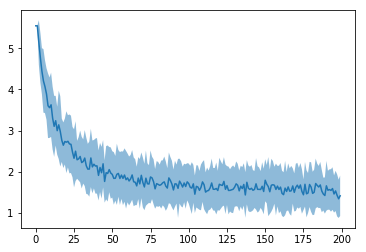

In [226]:
Aavg, Astd = np.average(A,axis=1), np.std(A,axis=1)
plt.plot(np.arange(Nshuffles),Aavg)
plt.fill_between(np.arange(Nshuffles),Aavg+Astd,Aavg-Astd,alpha=.5)
#plt.plot([0,Nshuffles-1],[-4*np.log(4),-4*np.log(4)])

(array([ 1.,  0.,  8.,  0.,  4., 17.,  1., 14.,  2.,  3.]),
 array([0.        , 0.23410656, 0.46821312, 0.70231968, 0.93642625,
        1.17053281, 1.40463937, 1.63874593, 1.87285249, 2.10695905,
        2.34106561]),
 <a list of 10 Patch objects>)

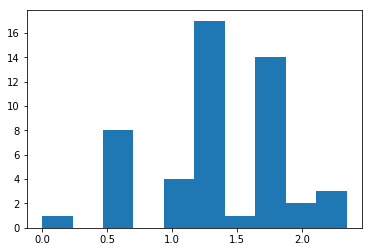

In [225]:
plt.hist(A[-1,:])

In [221]:
-5*np.log(4)

-6.931471805599453

In [202]:
Game = game(5,2)

In [203]:
Game.shuffle(100)

In [219]:
Game.flip(5,3)
Game.grid

[[0, 1, 4, 3], [1, 3, 0, 2], [4, 3, 1, 2], [3, 4, 0, 2], [4, 0, 1, 2], [], []]

In [220]:
Game.entropy()

-6.931471805599453

In [193]:
#reinforcement learning with Q table

In [283]:
lr, y = .8, .95
Nc, Ne = 6,2 
N = Nc + Ne
Nstates = 0
for i in range(Nc):
    Nstates += math.factorial(4*(i+1))//(math.factorial(4)*math.factorial(4*i))
Nactions = N*(N-1)
Nshuffle = 100
Q = np.zeros((Nstates,Nactions))#Nc*np.log(4)*np.ones((Nstates,Nactions))#np.zeros((Nstates,Nactions))

In [306]:
Game = game(Nc,Ne)
Game.shuffle(Nshuffle)
Game.finalize()
safe = copy.deepcopy(Game.grid)

In [307]:
safe

[[0, 1, 3, 4],
 [1, 1, 1, 5],
 [2, 2, 3, 5],
 [0, 3, 4, 2],
 [4, 4, 5, 2],
 [5, 3, 0, 0],
 [],
 []]

In [286]:
def compare(state1,state2):
    a = list(map(tuple,state1))
    b = list(map(tuple,state2))
    return a == b

In [341]:
Nepisodes, Ngreed = 10, 1000
allRewards = []

for i in range(Nepisodes):
    Game.grid = copy.deepcopy(safe)
    #Q = np.zeros((Nstates,Nactions))
    
    s = 0
    d = False
    totalReward = 0
    history = []
    history.append(s)
    rewards = []
    rewards.append(Game.entropy())
    statesList = []
    statesList.append(Game.grid)
    print('start: ', Game.grid)
    for j in range(Ngreed):
        a = np.argmax(Q[s,:] + np.random.randn(Nactions)*1/(i+1))
        state1, r, d = Game.step(a)
        #print(Game.grid)
        if statesList.count(state1) == 0:
            s1 = len(statesList)+1
            statesList.append(state1)
        else:
            s1 = statesList.index(state1)
        Q[s,a] += lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        totalReward += r
        rewards.append(r)
        history.append(s1)
        s = s1
        #if j >1000 and s == history[-2]:
        #    break
        if d:
            break
    allRewards.append(rewards)
    print('end: ',Game.grid)

start:  [[0, 1, 3, 4], [1, 1, 1, 5], [2, 2, 3, 5], [0, 3, 4, 2], [4, 4, 5, 2], [5, 3, 0, 0], [], []]
end:  [[5, 5, 5], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4], [], [5], [0, 0, 0, 0]]
start:  [[0, 1, 3, 4], [1, 1, 1, 5], [2, 2, 3, 5], [0, 3, 4, 2], [4, 4, 5, 2], [5, 3, 0, 0], [], []]
end:  [[], [1, 1, 1, 1], [2, 2, 2, 2], [0, 0, 0, 0], [4, 4, 4, 4], [], [5, 5, 5, 5], [3, 3, 3, 3]]
start:  [[0, 1, 3, 4], [1, 1, 1, 5], [2, 2, 3, 5], [0, 3, 4, 2], [4, 4, 5, 2], [5, 3, 0, 0], [], []]
end:  [[3, 3, 3, 3], [1, 1, 1, 1], [2, 2, 2, 2], [], [], [4, 4, 4, 4], [5, 5, 5, 5], [0, 0, 0, 0]]
start:  [[0, 1, 3, 4], [1, 1, 1, 5], [2, 2, 3, 5], [0, 3, 4, 2], [4, 4, 5, 2], [5, 3, 0, 0], [], []]
end:  [[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [4, 4, 4, 4], [], [], [3, 3, 3, 3], [5, 5, 5, 5]]
start:  [[0, 1, 3, 4], [1, 1, 1, 5], [2, 2, 3, 5], [0, 3, 4, 2], [4, 4, 5, 2], [5, 3, 0, 0], [], []]
end:  [[], [1, 1, 1, 1], [2, 2, 2, 2], [0, 0, 0, 0], [4, 4, 4, 4], [], [3, 3, 3, 3], [5, 5, 5, 5]]
st

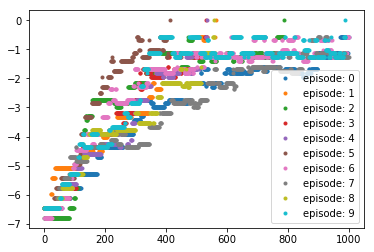

In [342]:
for i in range(Nepisodes):
    plt.plot(allRewards[i],'.',label='episode: {}'.format(i))
plt.legend()

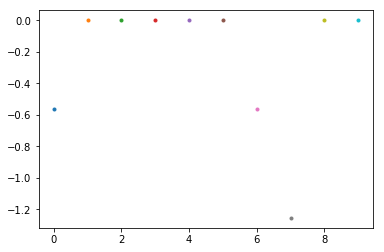

In [343]:
for i in range(Nepisodes):
    plt.plot(i,allRewards[i][-1],'.')

In [344]:
totalReward

-2144.6603680403687

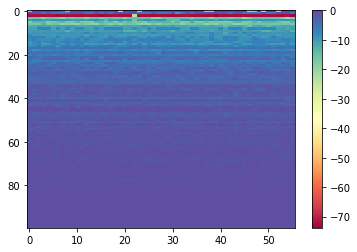

In [345]:
plt.imshow(Q[:100],aspect='auto',cmap='Spectral')
plt.colorbar()

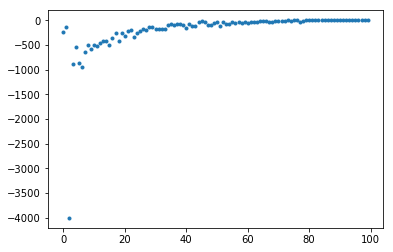

In [346]:
plt.plot(Q[:100].sum(axis=1),'.')